# Advanced preprocessing

# Table of Contents
- Load data
- Merge duplicated rows in `fcst` using mean / most recent fcst
- Convert the measure of `Cloud` in `fcst` to `obs`
- Interpolate fcst
- Convert dtype of 'time' in `energy`
- Merge fcst, obs, and energy
- Fill missing values in using ffill
- Add seasonality (day and year)

## Load data
- from basic_processing.ipynb

In [145]:
import pickle
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import warnings
warnings.filterwarnings('ignore')

In [146]:
with open('pickles/basic/dangjin_fcst_data.pkl','rb') as f:
    dangjin_fcst = pickle.load(f)
with open('pickles/basic/dangjin_obs_data.pkl','rb') as f:
    dangjin_obs = pickle.load(f)
with open('pickles/basic/ulsan_fcst_data.pkl','rb') as f:
    ulsan_fcst = pickle.load(f)
with open('pickles/basic/ulsan_obs_data.pkl', 'rb') as f:
    ulsan_obs = pickle.load(f)

energy = pd.read_csv(glob('../original_dataset/energy.csv')[0])

## Merge duplicated rows in `fcst`
## Option 1(current Plan B): Merge duplicated rows in `fcst` using mean

In [147]:
print('total rows:',dangjin_fcst['time'].shape[0])
print('unique rows:', dangjin_fcst['time'].unique().shape[0])
print('total rows:',ulsan_fcst['time'].shape[0])
print('unique rows:',ulsan_fcst['time'].unique().shape[0])

total rows: 162208
unique rows: 8788
total rows: 162208
unique rows: 8788


In [148]:
dangjin_fcst_unique_mean = dangjin_fcst.groupby('time').mean()
ulsan_fcst_unique_mean = ulsan_fcst.groupby('time').mean()

dangjin_fcst_unique_mean = dangjin_fcst_unique_mean.reset_index() # because time was set to index
ulsan_fcst_unique_mean = ulsan_fcst_unique_mean.reset_index()

In [149]:
dangjin_fcst_unique_mean

,time,Temperature,Humidity,Cloud,Wind_X,Wind_Y
0,2018-03-01 15:00:00,0.0,60.0,2.0,4.594039,-240.138102
1,2018-03-01 18:00:00,-2.0,60.0,1.0,4.932074,-225.872697
2,2018-03-01 21:00:00,-2.0,60.0,1.0,5.639833,-190.356464
3,2018-03-02 00:00:00,-2.0,52.5,1.0,5.709659,-136.663512
4,2018-03-02 03:00:00,-3.4,55.0,1.0,4.854618,-121.486735
...,...,...,...,...,...,...
8783,2021-03-03 12:00:00,7.0,40.0,1.0,-3.176148,-22.789567
8784,2021-03-03 15:00:00,8.0,40.0,1.0,-3.593860,-130.593860
8785,2021-03-03 18:00:00,5.0,55.0,1.0,-1.905256,-105.000000
8786,2021-03-03 21:00:00,1.0,80.0,1.0,-1.826397,45.204526


## Option 2(current Plan A): Merge duplicated rows in `fcst` using the most recent forecast

In [150]:
def merge_to_recent(data, time, due_hour = 21):
    '''
    @warning
    data에 'Forecast time'(기상 예측이 이루어진 시점) column이 존재해야 함.

    @description
    fcst에서 'time'이 중복되는 row들을 하나로 통합한다.
    이때, 가장 최근의 fcst data로 통합한다. (즉, 가장 최근의 fcst data 이외의 row는 모두 삭제한다.)
    '가장 최근'이라는 것은, 해당 'time'의 전날의 due_hour까지다. 
    예를 들어 2021-05-02 14:00:00(=time)를 예측하고, due_hour = 21이라면,
    2021-05-01 21:00:00 전까지의 row 중 가장 최근의 fcst로 통합한다.

    @parameters
    data: pd.DataFrame ; 통합이 이루어질 dataframe
    time: pd.Timestamp ; 통합하려는 time
    due_hour: int ; description 참고

    @return
    pd.Series ; 통합된 하나의 row

    '''
    # data only with the given time
    data_only_with_time = data.loc[data['time'] == time]
    
    # shift time
    time = time - pd.Timedelta(1, unit='days') # shifting 1 day to the past (yesterday)
    time = time.replace(hour=due_hour) # change 'hour' to DUE_HOUR

    # most recent forecast
    return data_only_with_time[data_only_with_time['Forecast time'] <= time].iloc[-1:,]


# example
TIME = pd.Timestamp('2018-03-03-21:00:00')
merge_to_recent(dangjin_fcst, TIME)

,time,Forecast time,Temperature,Humidity,Cloud,Wind_X,Wind_Y
212,2018-03-03 21:00:00,2018-03-02 20:00:00,9.0,85.0,3.0,-1.704996,97.270042


In [151]:
# apply merge_to_recent (dangjin_fcst)

# create a new merged df
dangjin_fcst_unique_recent = pd.DataFrame()

for time in dangjin_fcst['time'].unique():
    to_append = merge_to_recent(dangjin_fcst, time)
    dangjin_fcst_unique_recent = dangjin_fcst_unique_recent.append(to_append)

# reset index and drop 'Forecast time'
dangjin_fcst_unique_recent =  dangjin_fcst_unique_recent.reset_index(drop=True)
dangjin_fcst_unique_recent =  dangjin_fcst_unique_recent.drop('Forecast time', axis=1)
dangjin_fcst_unique_recent

,time,Temperature,Humidity,Cloud,Wind_X,Wind_Y
0,2018-03-02 00:00:00,-2.0,50.0,1.0,5.298564,-1.366635e+02
1,2018-03-02 03:00:00,-3.0,55.0,1.0,4.667902,-1.214867e+02
2,2018-03-02 06:00:00,-4.0,60.0,1.0,4.069439,-4.301988e+01
3,2018-03-02 09:00:00,-2.0,55.0,1.0,1.100000,-8.817457e-14
4,2018-03-02 12:00:00,2.0,45.0,1.0,-0.190809,-2.542414e+02
...,...,...,...,...,...,...
8780,2021-03-03 12:00:00,7.0,40.0,1.0,-3.176148,-2.278957e+01
8781,2021-03-03 15:00:00,8.0,40.0,1.0,-3.593860,-1.305939e+02
8782,2021-03-03 18:00:00,5.0,55.0,1.0,-1.905256,-1.050000e+02
8783,2021-03-03 21:00:00,1.0,80.0,1.0,-1.826397,4.520453e+01


In [152]:
# apply merge_to_recent (ulsan_fcst)

# create a new merged df
ulsan_fcst_unique_recent = pd.DataFrame()

for time in dangjin_fcst['time'].unique():
    to_append = merge_to_recent(ulsan_fcst, time)
    ulsan_fcst_unique_recent = ulsan_fcst_unique_recent.append(to_append)

# reset index and drop 'Forecast time'
ulsan_fcst_unique_recent =  ulsan_fcst_unique_recent.reset_index(drop=True)
ulsan_fcst_unique_recent =  ulsan_fcst_unique_recent.drop('Forecast time', axis=1)
ulsan_fcst_unique_recent

,time,Temperature,Humidity,Cloud,Wind_X,Wind_Y
0,2018-03-02 00:00:00,0.0,40.0,2.0,1.010290,-202.011846
1,2018-03-02 03:00:00,-1.0,45.0,2.0,0.872657,-261.511292
2,2018-03-02 06:00:00,-1.0,45.0,1.0,1.006547,-252.027422
3,2018-03-02 09:00:00,0.0,35.0,1.0,1.225671,-205.692035
4,2018-03-02 12:00:00,6.0,25.0,1.0,1.160653,-182.296887
...,...,...,...,...,...,...
8780,2021-03-03 12:00:00,9.0,45.0,3.0,0.377795,82.381331
8781,2021-03-03 15:00:00,9.0,45.0,3.0,-1.075104,103.627427
8782,2021-03-03 18:00:00,8.0,55.0,3.0,-1.165822,103.461868
8783,2021-03-03 21:00:00,6.0,65.0,3.0,-0.590453,98.866955


## Convert the measure of `Cloud` in `fcst` to `obs`
- `fcst`와 `obs`에서 `Cloud`의 단위는 다르다.
- `fcst`와 `obs`를 따로 input으로 넣는 경우 크게 상관 없으나, 이 둘을 합쳐서 쓰는 경우에는 단위가 통일되는 것이 좋아 보인다.  
- fcst: 1-맑음, 2-구름보통, 3-구름많음, 4-흐림  
- obs: 10분위(0~10); 낮을 수록 구름 적음

### method
- Cloud_fcst -> Cloud_obs
- Cloud_fcst = x (x=1,2,3,4)일 때 Cloud_obs의 mean으로 변환

In [153]:
# get dictionary to convert from cloud_fcst to cloud_obs

# merge (note that this is not the 'real' merged data)
dangjin_merged_for_cloud = pd.merge(dangjin_fcst_unique_recent, dangjin_obs, on='time', suffixes=('_fcst','_obs'))
ulsan_merged_for_cloud = pd.merge(ulsan_fcst_unique_recent, ulsan_obs, on='time', suffixes=('_fcst','_obs'))

# mean
def cloud_from_fcst_to_obs(data):
    '''
    @parameter
    data: pd.DataFrame; data should contain both 'Cloud_fcst' and 'Cloud_obs'

    @return
    dictionary ; its key is the value of 'Cloud_fcst', its value is the value of 'Cloud_obs'
    '''

    # dropna
    data.dropna(inplace=True)
    # unique cloud_fcsts
    cloud_fcsts = data['Cloud_fcst'].unique()
    # dict to convert from fcst to obs
    convert = {cloud_fcst:0 for cloud_fcst in cloud_fcsts}

    # mean
    for cloud_fcst in cloud_fcsts:
        sliced_df = data[data['Cloud_fcst'] == cloud_fcst]
        convert[cloud_fcst] = sliced_df['Cloud_obs'].mean()

    return convert

dangjin_convert_cloud = cloud_from_fcst_to_obs(dangjin_merged_for_cloud)
ulsan_convert_cloud = cloud_from_fcst_to_obs(ulsan_merged_for_cloud)
dangjin_convert_cloud, ulsan_convert_cloud

({1.0: 2.7635372029606544,
  2.0: 3.8820678513731823,
  3.0: 6.18494516450648,
  4.0: 7.961345381526105},
 {2.0: 3.5910064239828694,
  1.0: 1.721059516023545,
  3.0: 6.145117540687161,
  4.0: 8.638197424892704})

In [154]:
# apply the convert-dictionary
dangjin_fcst_unique_recent['Cloud'].replace(dangjin_convert_cloud, inplace=True)
ulsan_fcst_unique_recent['Cloud'].replace(ulsan_convert_cloud, inplace=True)
display(dangjin_fcst_unique_recent['Cloud'])
display(ulsan_fcst_unique_recent['Cloud'])

0       2.763537
1       2.763537
2       2.763537
3       2.763537
4       2.763537
          ...   
8780    2.763537
8781    2.763537
8782    2.763537
8783    2.763537
8784    2.763537
Name: Cloud, Length: 8785, dtype: float64

0       3.591006
1       3.591006
2       1.721060
3       1.721060
4       1.721060
          ...   
8780    6.145118
8781    6.145118
8782    6.145118
8783    6.145118
8784    6.145118
Name: Cloud, Length: 8785, dtype: float64

## Interpolate fcst
- code from @김진수

In [155]:
# code from @김진수
# linear interpolation

def interpolation(df):

    df_copy = df.copy()
    var_names = df.columns

    total_s = list()
    time_list = list()
    
    for var_name in var_names:
        s = list()
        for i in range(df_copy.shape[0] - 1):
            timedeltas = df_copy["time"][i+1] - df_copy["time"][i]
            n_intervals = int(timedeltas / np.timedelta64(1, "h"))

            for j in range(n_intervals):
        
                if var_name == "time":
                    time_stamps = df_copy["time"][i] + timedeltas * j / n_intervals
                    time_list.append(time_stamps)
                else:
                    add_ = df_copy[var_name][i] + (df_copy[var_name][i+1] - df_copy[var_name][i]) / n_intervals * j
                    s.append(add_)

        if var_name == "time":
            time_list = np.array(time_list).reshape(-1,1)
            total_s.append(time_list)
        else:
            s = np.array(s).reshape(-1,1)
            total_s.append(s)

    total_s = np.array(total_s).T.reshape(-1, len(var_names))
    df_converted = pd.DataFrame(total_s, columns = var_names)

    return df_converted

In [176]:
dangjin_fcst_interpolated = interpolation(dangjin_fcst_unique_recent)
ulsan_fcst_interpolated = interpolation(ulsan_fcst_unique_recent)
dangjin_obs_interpolated = interpolation(dangjin_obs)
ulsan_obs_interpolated = interpolation(ulsan_obs)

## Convert dtype of 'time' in `energy`
- 'time' of `energy` is 'object'. 
- However, `pd.to_datetime` doesn't accepts '24:00:00' as an hour. Instead accepts '00:00:00'.
- Therefore, custom function is needed.

In [157]:
def to_datetime_for_energy(date_str):
    if date_str[11:13] == '24':
        date_str = date_str[0:11] + '00' + date_str[13:]
        return pd.to_datetime(date_str) + pd.Timedelta(1, unit='days')

    else:
        return pd.to_datetime(date_str)

print(to_datetime_for_energy('2018-03-01 24:00:00'))

2018-03-02 00:00:00


In [158]:
energy['time'] = energy['time'].apply(to_datetime_for_energy)

## Fill missing values - obs

obs:  
- median을 활용.

 참고: fcst에서는 na 없음

In [159]:
# count na
print(dangjin_obs_interpolated.isna().sum())
print(ulsan_obs_interpolated.isna().sum())

time              0
Temperature      47
Humidity         43
Cloud          4101
Wind_X           44
Wind_Y           44
dtype: int64
time              0
Temperature       7
Humidity          2
Cloud          1259
Wind_X            2
Wind_Y            2
dtype: int64


(array([2450., 1245.,   13.,   39.,   94.,   24.,   66.,    9.,  141.,
          20.]),
 array([17591.        , 17693.05416667, 17795.10833333, 17897.1625    ,
        17999.21666667, 18101.27083333, 18203.325     , 18305.37916667,
        18407.43333333, 18509.4875    , 18611.54166667]),
 <BarContainer object of 10 artists>)

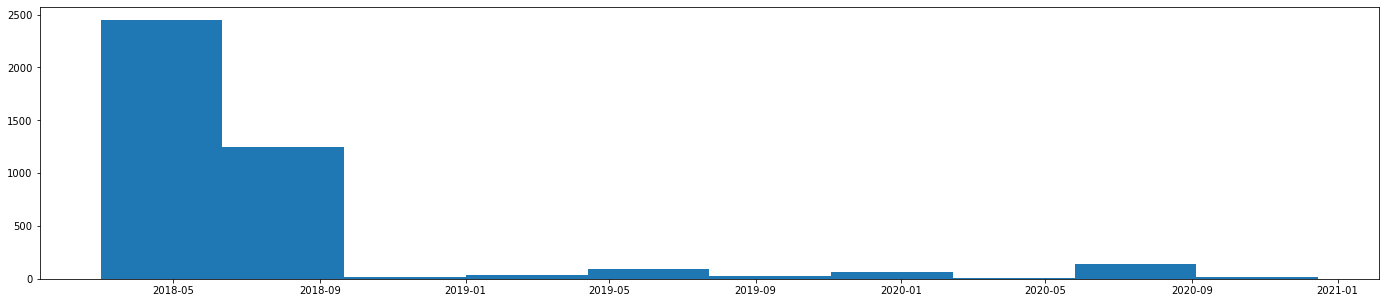

In [160]:
# hist
dj_cloud_na = dangjin_obs_interpolated[dangjin_obs_interpolated['Cloud'].isna()]
plt.figure(figsize=(24,5))
plt.hist(dj_cloud_na['time'])

(array([776., 408.,   0.,  11.,  15.,   0.,   8.,   3.,  28.,  10.]),
 array([17591.04166667, 17690.72083333, 17790.4       , 17890.07916667,
        17989.75833333, 18089.4375    , 18189.11666667, 18288.79583333,
        18388.475     , 18488.15416667, 18587.83333333]),
 <BarContainer object of 10 artists>)

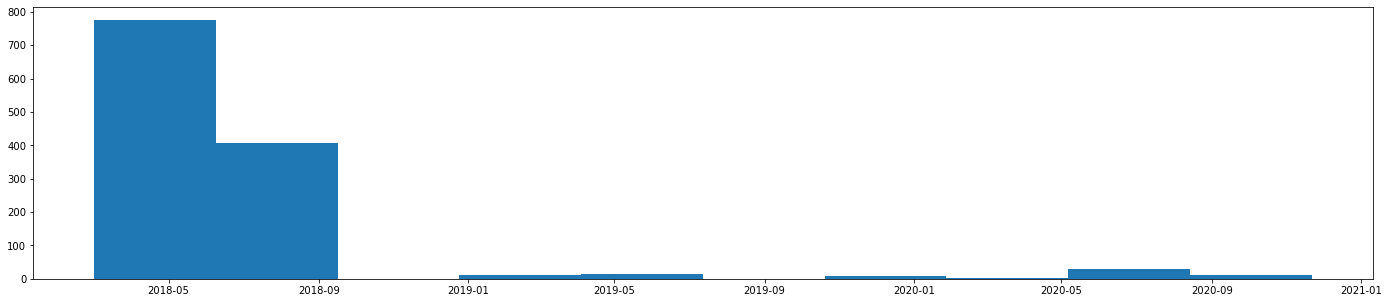

In [161]:
uls_cloud_na = ulsan_obs_interpolated[ulsan_obs_interpolated['Cloud'].isna()]
plt.figure(figsize=(24,5))
plt.hist(uls_cloud_na['time'])

In [162]:
dangjin_obs_filled = dangjin_obs_interpolated.copy()
ulsan_obs_filled = ulsan_obs_interpolated.copy()

for col in dangjin_obs_interpolated.columns[1:]: 
    median = dangjin_obs_interpolated.median()[col]
    dangjin_obs_filled = dangjin_obs_interpolated.fillna(median) 

for col in ulsan_obs_interpolated.columns[1:]:
    median = ulsan_obs_interpolated.median()[col]
    ulsan_obs_filled = ulsan_obs_interpolated.fillna(median)   

## Fill missing values - energy

enery:  
- dangjin_floating과 dangjin_warehouse에서 n/a가 나타남.  
- dangjin mean과 dangjin_floating mean, dangjin_warehouse mean과의 비를 통해 채운다.

In [163]:
energy.isna().sum()

time                  0
dangjin_floating     24
dangjin_warehouse    48
dangjin               0
ulsan                 0
dtype: int64

In [164]:
# convert dangjin to dangjin_warehouse or dangjin_floating via 비율 of mean
energy_mean_series = energy.mean(axis=0)
dj_to_djwh = energy_mean_series['dangjin_warehouse'] / energy_mean_series['dangjin'] 
dj_to_djflt = energy_mean_series['dangjin_floating'] / energy_mean_series['dangjin'] 

dj_to_djwh, dj_to_djflt

(0.6621875391769269, 0.8739952702591247)

In [165]:
# slice where data is na
na_dangjin_warehouse = energy.loc[energy['dangjin_warehouse'].isna()] # df where dangjin_warehouse = na
na_dangjin_warehouse.loc[:,'dangjin_warehouse'] = na_dangjin_warehouse['dangjin'] * dj_to_djwh

na_dangjin_floating = energy.loc[energy['dangjin_floating'].isna()] # df where dangjin_floating = na
na_dangjin_floating.loc[:,'dangjin_floating'] = na_dangjin_floating['dangjin'] * dj_to_djflt

In [166]:
# create filled df
energy_filled = energy.copy()

energy_filled[energy['dangjin_warehouse'].isna()] = na_dangjin_warehouse
energy_filled[energy['dangjin_floating'].isna()] = na_dangjin_floating

energy_filled.isna().sum()

time                 0
dangjin_floating     0
dangjin_warehouse    0
dangjin              0
ulsan                0
dtype: int64

## Merge fcst, obs, and energy
- inner merge on 'time'

In [167]:
dangjin_merged_ = pd.merge(dangjin_fcst_filled, dangjin_obs_filled, on='time', suffixes=('_obs','_fcst'))
dangjin_merged = pd.merge(dangjin_merged_, energy_filled.loc[:,['time','dangjin_floating','dangjin_warehouse','dangjin']], on='time')

ulsan_merged_ = pd.merge(ulsan_fcst_filled, ulsan_obs_filled, on='time', suffixes=('_obs','_fcst'))
ulsan_merged = pd.merge(ulsan_merged_, energy_filled.loc[:,['time','ulsan']], on='time')

display(dangjin_merged)
display(ulsan_merged)

,time,Temperature_obs,Humidity_obs,Cloud_obs,Wind_X_obs,Wind_Y_obs,Temperature_fcst,Humidity_fcst,Cloud_fcst,Wind_X_fcst,Wind_Y_fcst,dangjin_floating,dangjin_warehouse,dangjin
0,2018-03-02 00:00:00,-2.000000,50.000000,2.763537,5.298564,-136.663512,-2.7,56.0,0.0,3.700000,-8.817457e-14,0.0,0.0,0
1,2018-03-02 01:00:00,-2.333333,51.666667,2.763537,5.088343,-131.604586,-2.8,53.0,0.0,3.800000,-8.817457e-14,0.0,0.0,0
2,2018-03-02 02:00:00,-2.666667,53.333333,2.763537,4.878123,-126.545661,-3.2,52.0,0.0,2.500000,-8.817457e-14,0.0,0.0,0
3,2018-03-02 03:00:00,-3.000000,55.000000,2.763537,4.667902,-121.486735,-3.5,50.0,0.0,2.443201,6.840403e+00,0.0,0.0,0
4,2018-03-02 04:00:00,-3.333333,56.666667,2.763537,4.468414,-95.331116,-4.2,55.0,0.0,0.899903,3.830222e+01,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25602,2021-01-31 18:00:00,6.000000,75.000000,7.961345,-3.374657,-22.789567,7.8,70.0,8.0,-1.879385,-6.840403e+01,10.0,6.0,0
25603,2021-01-31 19:00:00,6.000000,76.666667,7.961345,-3.521363,-3.549990,6.7,75.0,8.0,-1.409539,-6.840403e+01,0.0,0.0,0
25604,2021-01-31 20:00:00,6.000000,78.333333,7.961345,-3.668069,15.689587,6.2,77.0,8.0,-0.751754,-6.840403e+01,0.0,0.0,0
25605,2021-01-31 21:00:00,6.000000,80.000000,7.961345,-3.814776,34.929164,5.3,82.0,8.0,-0.449951,-1.761902e+02,0.0,0.0,0


,time,Temperature_obs,Humidity_obs,Cloud_obs,Wind_X_obs,Wind_Y_obs,Temperature_fcst,Humidity_fcst,Cloud_fcst,Wind_X_fcst,Wind_Y_fcst,ulsan
0,2018-03-02 00:00:00,0.000000,40.000000,3.591006,1.010290,-202.011846,1.3,37.0,-68.404029,3.194955,-1.162868e+02,0
1,2018-03-02 01:00:00,-0.333333,41.666667,3.591006,0.964412,-221.844994,0.5,42.0,-68.404029,2.000000,-8.817457e-14,0
2,2018-03-02 02:00:00,-0.666667,43.333333,3.591006,0.918535,-241.678143,-0.4,46.0,-68.404029,2.300000,-8.817457e-14,0
3,2018-03-02 03:00:00,-1.000000,45.000000,3.591006,0.872657,-261.511292,-0.9,48.0,9.000000,1.879385,6.840403e+00,0
4,2018-03-02 04:00:00,-1.000000,45.000000,2.967691,0.917287,-258.350002,-1.5,51.0,8.000000,2.161293,-1.162868e+02,0
...,...,...,...,...,...,...,...,...,...,...,...,...
25602,2021-01-31 18:00:00,9.000000,55.000000,8.638197,-2.472747,-61.185365,9.3,43.0,0.000000,-3.400000,2.204364e-14,8
25603,2021-01-31 19:00:00,8.666667,60.000000,8.638197,-2.629993,-75.790243,8.8,50.0,5.000000,-2.349232,-6.840403e+01,0
25604,2021-01-31 20:00:00,8.333333,65.000000,8.638197,-2.787240,-90.395122,8.7,49.0,1.000000,-3.664801,-6.840403e+01,0
25605,2021-01-31 21:00:00,8.000000,70.000000,8.638197,-2.944486,-105.000000,8.4,51.0,7.000000,-1.542690,-1.761902e+02,0


## Add seasonality (day and year)

In [168]:
# function for day_of_year
def day_of_year(datetime): #pd.datetime
    return pd.Period(datetime, freq='D').day_of_year

print(dangjin_fcst_filled.iloc[0]['time'])
print(day_of_year(dangjin_fcst_filled.iloc[0]['time']))

2018-03-02 00:00:00
61


In [169]:
# function
def add_seasonality(df):
    new_df = df.copy()
    
    new_df['Day_cos'] = new_df['time'].apply(lambda x: np.cos(x.hour * (2 * np.pi) / 24))
    new_df['Day_sin'] = new_df['time'].apply(lambda x: np.sin(x.hour * (2 * np.pi) / 24))

    new_df['Year_cos'] = new_df['time'].apply(lambda x: np.cos(day_of_year(x) * (2 * np.pi) / 365))
    new_df['Year_sin'] = new_df['time'].apply(lambda x: np.sin(day_of_year(x) * (2 * np.pi) / 365))

    return new_df

In [170]:
# apply
dangjin_merged_with_season = add_seasonality(dangjin_merged)
ulsan_merged_with_season = add_seasonality(ulsan_merged)

dangjin_fcst_with_season = add_seasonality(dangjin_fcst_filled)
ulsan_fcst_with_season = add_seasonality(ulsan_fcst_filled)
dangjin_obs_with_season = add_seasonality(dangjin_obs_filled)
ulsan_obs_with_season = add_seasonality(ulsan_obs_filled)

In [171]:
# check
print(dangjin_fcst_with_season.loc[4,['time','Day_cos','Day_sin','Year_cos','Year_sin']])
print(dangjin_fcst_with_season.loc[4 + 24,['time','Day_cos','Day_sin']])
print(dangjin_fcst_with_season.loc[4 + 24*365,['time','Year_cos','Year_sin']])

time        2018-03-02 04:00:00
Day_cos                     0.5
Day_sin                0.866025
Year_cos               0.497513
Year_sin               0.867456
Name: 4, dtype: object
time       2018-03-03 04:00:00
Day_cos                    0.5
Day_sin               0.866025
Name: 28, dtype: object
time        2019-03-02 04:00:00
Year_cos               0.497513
Year_sin               0.867456
Name: 8764, dtype: object


## Pickle dfs

In [172]:
with open('pickles/dangjin_merged.pkl','wb') as f:
    pickle.dump(dangjin_merged_with_season,f)
with open('pickles/ulsan_merged.pkl','wb') as f:
    pickle.dump(ulsan_merged_with_season,f)

with open('pickles/dangjin_fcst.pkl','wb') as f:
    pickle.dump(dangjin_fcst_with_season, f)
with open('pickles/dangjin_obs.pkl','wb') as f:
    pickle.dump(dangjin_obs_with_season, f)
with open('pickles/ulsan_fcst.pkl','wb') as f:
    pickle.dump(ulsan_fcst_with_season, f)
with open('pickles/ulsan_obs.pkl','wb') as f:
    pickle.dump(ulsan_obs_with_season, f)
    